In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.10/09


In [3]:
infile_r = None  # input file handle

def load_pgun():
  global infile_r
  infile = '../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root'
  #if use_condor:
  #  infile = 'root://cmsio5.rc.ufl.edu//store/user/jiafulow/L1MuonTrigger/P2_10_1_5/SingleMuon_Toy_2GeV/'+infile
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  #tree = TreeChain('ntupler/tree', [infile])
  print('[INFO] Opening file: %s' % infile)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  return tree

In [4]:
#maxEvents = 1000
maxEvents = 50000

debug = 0

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

eta_bins = (1.2, 1.4, 1.55, 1.7, 1.8, 1.98, 2.15, 2.5)
eta_bins = eta_bins[::-1]
pt_bins = (-0.50, -0.333333, -0.25, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 0.25, 0.333333, 0.50)
nlayers = 12  # 5 (CSC) + 4 (RPC) + 3 (GEM)

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

def analysis(strip_unit=8*2, stride=1, verbose=1):
  tree = load_pgun()
  
  outs = []

  # Loop over events
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    if verbose and (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))
    
    # Skip events with very few hits
    if not len(evt.hits) >= 4:
      continue

    # Skip events without ME1 hits
    has_ME1 = False
    for ihit, hit in enumerate(evt.hits):
      if hit.type == kCSC and hit.station == 1:
        has_ME1 = True
        break
      elif hit.type == kME0 and hit.station == 1:
        has_ME1 = True
        break
    if not has_ME1:
      continue
    
    part = evt.particles[0]  # particle gun
    part.invpt = np.true_divide(part.q, part.pt)
    
    # Find the best sector
    sector_cnt_array = np.zeros((12,), dtype=np.int32)
    sector_phi_array = np.empty((12,), dtype=np.object)
    for ind in np.ndindex(sector_phi_array.shape):
      sector_phi_array[ind] = []
    
    for ihit, hit in enumerate(evt.hits):
      #print(".. hit  {0} {1} {2} {3} {4} {5} {6} {7} {8} {9} {10} {11}".format(ihit, hit.bx, hit.type, hit.station, hit.ring, hit.sector, hit.fr, hit.sim_phi, hit.sim_theta, hit.time, hit.sim_tp1, hit.sim_tp2))
      
      endsec = find_endsec(hit.endcap, hit.sector)
      assert(hit.emtf_phi < 5040)  # 84*60
      
      sector_cnt_array[endsec] += 1
      sector_phi_array[endsec].append(hit.emtf_phi)
    
    best_sector = np.argmax(sector_cnt_array)
    #print "ievt {0} nhits {1}".format(ievt, len(evt.hits))
    #print "..", sector_cnt_array
    #print "..", sector_cnt_array[best_sector]
    #print "..", sector_phi_array[best_sector]
    
    # Find the best phi bin
    phis = sector_phi_array[best_sector]
    phis = np.asarray(phis)
    
    # Overlapping bins
    bins1 = np.arange(0, 5120, strip_unit)
    bins2 = np.arange(-strip_unit/2, 5120+strip_unit/2, strip_unit)
    if len(bins2):
      binned_phis1 = np.digitize(phis, bins=bins1[1:])  # skip lowest edge
      binned_phis2 = np.digitize(phis, bins=bins2[1:])  # skip lowest edge
      binned_phis_with_counts1 = np.unique(binned_phis1, return_counts=True)
      binned_phis_with_counts2 = np.unique(binned_phis2, return_counts=True)
      if np.max(binned_phis_with_counts1[1]) >= np.max(binned_phis_with_counts2[1]):
        bins = bins1
        binned_phis = binned_phis1
        binned_phis_with_counts = binned_phis_with_counts1
      else:
        bins = bins2
        binned_phis = binned_phis2
        binned_phis_with_counts = binned_phis_with_counts2
    else:
      bins = bins1
      binned_phis = np.digitize(phis, bins=bins[1:])  # skip lowest edge
      binned_phis_with_counts = np.unique(binned_phis, return_counts=True)
    
    best_bin_tmp = np.argmax(binned_phis_with_counts[1])
    best_bin = binned_phis_with_counts[0][best_bin_tmp]
    best_bin_cnt = binned_phis_with_counts[1][best_bin_tmp]
    #frac = float(best_bin_cnt)/len(phis)
    
    best_bin_phis = phis[binned_phis == best_bin]
    if len(best_bin_phis):
      delta = np.max(best_bin_phis) - np.min(best_bin_phis)
    else:
      delta = 0
    
    # Debug
    if verbose and debug:
      print part.pt, best_bin, len(phis), best_bin_cnt, delta, phis, binned_phis_with_counts1, binned_phis_with_counts2
    
    outs.append((part.pt, len(phis), best_bin_cnt, delta))

  return np.asarray(outs)

In [5]:
#eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30., 34., 40., 48., 60., 80., 120.)
eff_pt_bins = (0., 0.5, 1., 1.5, 2., 3., 4., 5., 6., 7., 8., 10., 12., 14., 16., 18., 20., 22., 24., 27., 30.)
edges = np.asarray(eff_pt_bins)

def post_analysis(outs):
  xdata = (edges[1:] + edges[:-1])/2

  denom = np.zeros_like(xdata, dtype=np.float32)
  numer = np.zeros_like(xdata, dtype=np.float32)

  for o in outs:
    (pt, cnt, bin_cnt, delta) = o
    x = np.digitize(pt, bins=eff_pt_bins[1:])  # skip lowest edge
    if x == len(xdata):
      x -= 1
    denom[x] += 1
    if float(bin_cnt)/cnt > 7./8:
      numer[x] += 1

  denom[denom == 0] = 1
  ydata = np.true_divide(numer, denom)
  return xdata, ydata

In [6]:
# Run analysis

strip_unit = 5120/8
outs = analysis(strip_unit=strip_unit)
xdata, ydata = post_analysis(outs)

print strip_unit
print outs
print xdata, ydata

[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
Processing event: 8000
Processing event: 9000
Processing event: 10000
Processing event: 11000
Processing event: 12000
Processing event: 13000
Processing event: 14000
Processing event: 15000
Processing event: 16000
Processing event: 17000
Processing event: 18000
Processing event: 19000
Processing event: 20000
Processing event: 21000
Processing event: 22000
Processing event: 23000
Processing event: 24000
Processing event: 25000
Processing event: 26000
Processing event: 27000
Processing event: 28000
Processing event: 29000
Processing event: 30000
Processing event: 31000
Processing event: 32000
Processing event: 33000
Processing event: 34000
Processing event: 35000
Processing event: 36000
Processing event: 37000
Processing event: 38000
Processin

In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

Using strip_unit 32
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 64
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 128
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 256
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 320
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 640
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 1280
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root
Using strip_unit 2560
[INFO] Opening file: ../test7/ntuple_SingleMuon_Toy_2GeV_add.6.root


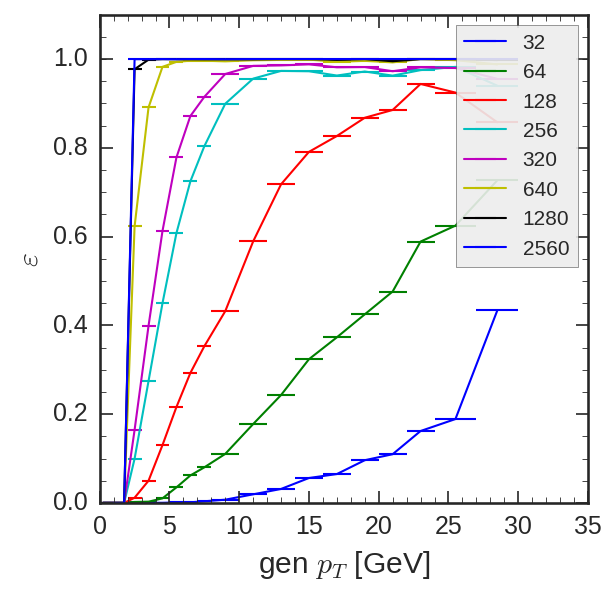

In [8]:
# Run more analysis

if True:
  plt.figure()

  strip_units = [8*4, 8*8, 8*16, 8*32, 5120/16, 5120/8, 5120/4, 5120/2]

  for strip_unit in strip_units:
    print('Using strip_unit {0}'.format(strip_unit))
    outs = analysis(strip_unit=strip_unit, verbose=0)
    xdata, ydata = post_analysis(outs)
    xerr = (edges[1:] - edges[:-1])/2
    #plt.errorbar(xdata, ydata, xerr=xerr, marker=',', fmt='o', lw=1)
    plt.errorbar(xdata, ydata, xerr=xerr, marker=',', lw=1)

  leg = plt.legend(strip_units, frameon=True, framealpha=0.9, fontsize=10)
  leg.get_frame().set_facecolor('#ededed')
  plt.xlim(0,35)
  plt.ylim(0,1.1)
  plt.xlabel(r'gen $p_{T}$ [GeV]')
  plt.ylabel(r'$\varepsilon$')
  plt.show()